In [5]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

!pip install tensorflow-gpu
!pip install nltk
!pip install keras
!pip install wordcloud

In [6]:
import numpy as np
import nltk
import joblib
import re
#import pydot
from wordcloud import WordCloud, ImageColorGenerator
#import tensorflow as tf
#from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import pandas as pd
import seaborn as sns
#import plotly.graph_objects as go
#import chart_studio.plotly as py
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pandas.plotting import register_matplotlib_converters
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

#import numpy as np 
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
#from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
#from keras.callbacks import EarlyStopping
#from keras.layers import Dropout
#import re
#from nltk.corpus import stopwords
#from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
#from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df = pd.read_csv('data/coded_sub_section.csv',header=0)


In [8]:
df.head()

,Textfile,Determination_Year,Sub_Header,Sub_Section,Cond_Category,EScore
0,/home/admin/dockers/masters/data/pdfminer/sear...,2012.0,Pollution of Waters,Except as may be expressly provided by a OEH ...,1,0.8550
1,/home/admin/dockers/masters/data/pdfminer/sear...,2012.0,Creek Diversions for the Underground Project,The Proponent shall carry out the proposed di...,1,0.4275
2,/home/admin/dockers/masters/data/pdfminer/sear...,2012.0,Creek Diversions for the Underground Project,Within 6 months of completing the construction...,1,0.6650
3,/home/admin/dockers/masters/data/pdfminer/sear...,2012.0,Discharge,Except as may be expressly provided for by an...,1,0.8550
4,/home/admin/dockers/masters/data/pdfminer/sear...,2012.0,Discharge,However water may be transferred between the s...,1,0.5400


In [9]:
df.shape

(1032, 6)

In [10]:
df.Cond_Category.value_counts()

3    401
4    262
1    197
2    172
Name: Cond_Category, dtype: int64

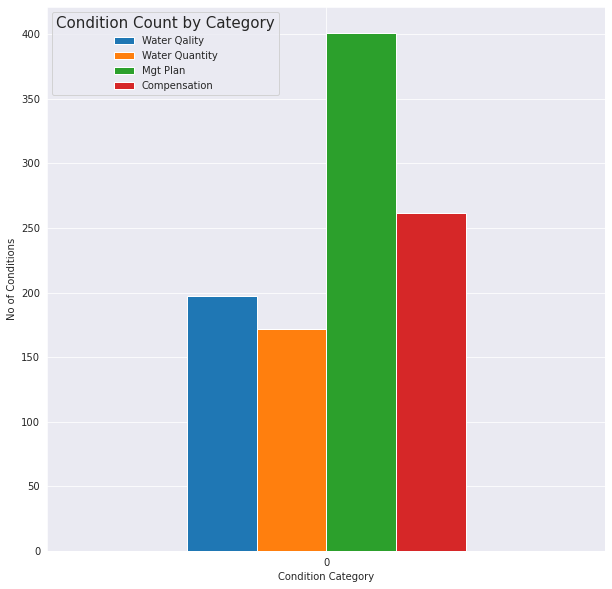

In [15]:
fields = [197,172,401,262]
data = []
data.append(fields)
cols = ['Water Qality','Water Quantity','Mgt Plan','Compensation']
df_cat = pd.DataFrame(data=data,columns=cols)
sns.set_style("darkgrid")
df_cat.plot.bar(rot=0,xlabel='Condition Category',ylabel='No of Conditions',figsize=(10,10)).legend(loc='upper left',title='Condition Count by Category',title_fontsize=15)

#df['Stars'].value_counts().plot.bar(rot=0,title='Condition Star Count Chart',xlabel='Stars',ylabel='No of Conditions',figsize=(10,10))

In [166]:

df.median()


Determination_Year    2016.0000
Cond_Category            3.0000
EScore                   0.4275
dtype: float64

In [167]:
df.mode()

,Textfile,Determination_Year,Sub_Header,Sub_Section,Cond_Category,EScore
0,/home/admin/dockers/masters/data/pdfminer/search/MP08_0144-Mod-5.txt,2015.0,Water Management Plan,The compensatory water supply measures must provide an alternative longterm supply of water that is equivalent to the loss attributed to the project.,3,0.4275


In [168]:
df.describe()

,Determination_Year,Cond_Category,EScore
count,959.000000,1032.000000,1032.000000
mean,2016.163712,2.705426,0.496195
std,2.575235,1.048045,0.299894
min,2012.000000,1.000000,0.000000
25%,2014.000000,2.000000,0.264937
50%,2016.000000,3.000000,0.427500
75%,2018.000000,4.000000,0.700000
max,2021.000000,4.000000,1.000000


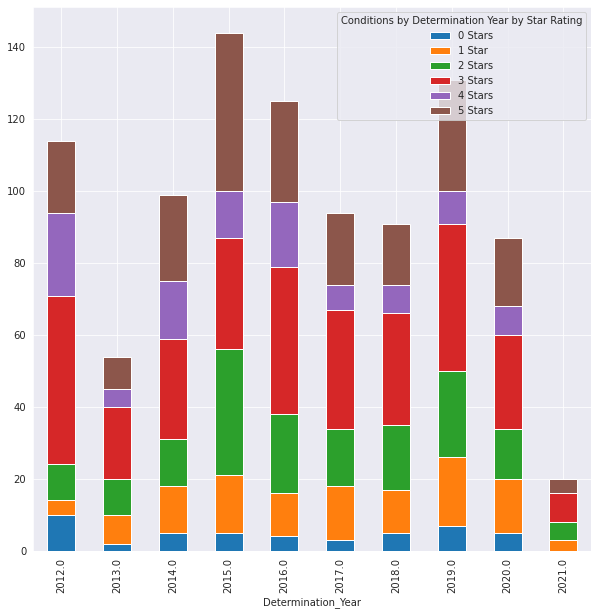

In [180]:
df.groupby(['Determination_Year','Stars']).size().unstack().plot(kind='bar',stacked=True,figsize=(10,10)).legend(["0 Stars","1 Star","2 Stars","3 Stars","4 Stars","5 Stars"],loc='upper right', title="Conditions by Determination Year by Star Rating")
#xticks=[1:"Water Quality",2:"Water Quantity",3:"Mgt Rpt",4:"Compensation"]
sns.set_style("darkgrid")
plt.show()

In [170]:
df.Determination_Year.value_counts()

2015.0    144
2019.0    131
2016.0    125
2012.0    114
2014.0     99
2017.0     94
2018.0     91
2020.0     87
2013.0     54
2021.0     20
Name: Determination_Year, dtype: int64

<AxesSubplot:title={'center':'Condition Count Chart by Year'}, xlabel='Year', ylabel='No of Conditions'>

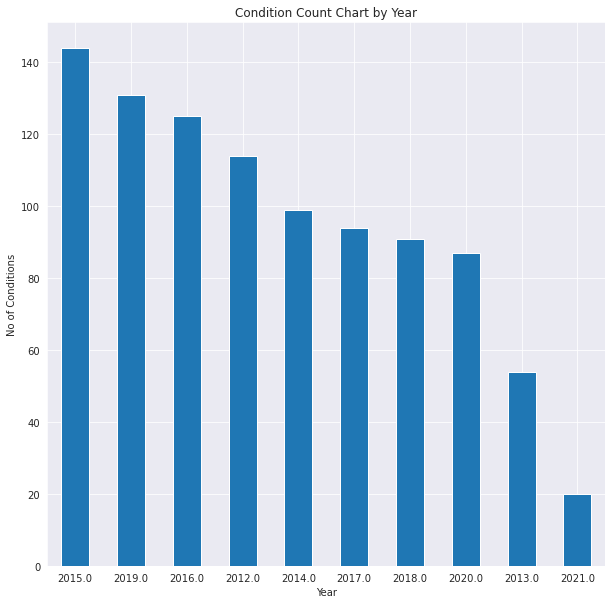

In [171]:
df['Determination_Year'].value_counts().plot.bar(rot=0,title='Condition Count Chart by Year',xlabel='Year',ylabel='No of Conditions',figsize=(10,10))

#df_word[0].value_counts().plot.bar(rot=0,title='Condition Word Count Chart',xlabel='Word Count',ylabel='No of Conditions',figsize=(25,10))

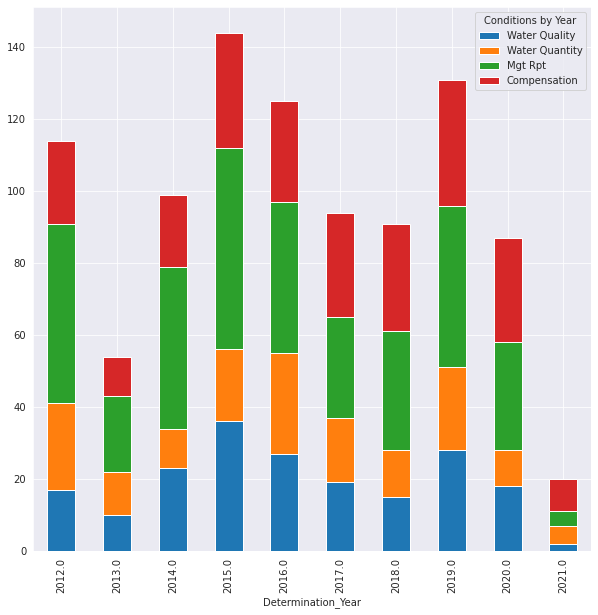

In [172]:
#df['Determination_Year'].groupby(['Cond_Category']).value_counts().plot.bar(rot=0,title='Condition Count Chart by Year',xlabel='Year',ylabel='No of Conditions',figsize=(10,10))

df.groupby(['Determination_Year','Cond_Category']).size().unstack().plot(kind='bar',stacked=True,figsize=(10,10)).legend(["Water Quality","Water Quantity","Mgt Rpt","Compensation"],loc='upper right', title="Conditions by Year")
sns.set_style("darkgrid")
plt.show()

In [173]:
#pd.set_option('display.max_rows', None)
##pd.set_option('display.max_columns', None)
##pd.set_option('display.width', None)
##pd.set_option('display.max_colwidth', -1)
#print (df.groupby(["Determination_Year","Textfile"]).count())

In [174]:
#df = df.drop(['Textfile','Sub_Header','Cond_Category','Determination_Year'],axis=1)

In [175]:
df['Stars'] = 0
df.head()

,Textfile,Determination_Year,Sub_Header,Sub_Section,Cond_Category,EScore,Stars
0,/home/admin/dockers/masters/data/pdfminer/search/MP08_0256-Mod-2.txt,2012.0,Pollution of Waters,Except as may be expressly provided by a OEH Environment Protection Licence the Proponent shall comply with section 120 of the Protection of the Environment Operations Act 1997 during the carrying out of the Project.,1,0.8550,0
1,/home/admin/dockers/masters/data/pdfminer/search/MP08_0102-Mod-1.txt,2012.0,Creek Diversions for the Underground Project,The Proponent shall carry out the proposed diversions of Bettys Creek and Main Creek in the underground project area to the satisfaction of the DirectorGeneral.,1,0.4275,0
2,/home/admin/dockers/masters/data/pdfminer/search/MP08_0102-Mod-1.txt,2012.0,Creek Diversions for the Underground Project,Within 6 months of completing the construction of the diversions the Proponent shall submit an asexecuted report certified by a practising engineer to the DirectorGeneral and NOW.,1,0.6650,0
3,/home/admin/dockers/masters/data/pdfminer/search/MP07_0087-Mod-2.txt,2012.0,Discharge,Except as may be expressly provided for by an EPL or in accordance with section 120 of the Protection of the Environment Operations Act 1997 the Proponent shall not discharge any mine water from the site.,1,0.8550,0
4,/home/admin/dockers/masters/data/pdfminer/search/MP07_0087-Mod-2.txt,2012.0,Discharge,However water may be transferred between the site and the adjoining Donaldson Coal Mine andor Abel Coal Mine in accordance with any approved Water Management Plan see below.,1,0.5400,0


In [176]:
for i in range(len(df)):
    if df.iloc[i,5] == 0:
        df.iloc[i,6] = 0
    elif df.iloc[i,5] < .2:
        df.iloc[i,6] = 1
    elif df.iloc[i,5] < .4:
        df.iloc[i,6] = 2
    elif df.iloc[i,5] < .6:
        df.iloc[i,6] = 3
    elif df.iloc[i,5] < .8:
        df.iloc[i,6] = 4
    elif df.iloc[i,5] > .8:
        df.iloc[i,6] = 5  
        
df.head()

,Textfile,Determination_Year,Sub_Header,Sub_Section,Cond_Category,EScore,Stars
0,/home/admin/dockers/masters/data/pdfminer/search/MP08_0256-Mod-2.txt,2012.0,Pollution of Waters,Except as may be expressly provided by a OEH Environment Protection Licence the Proponent shall comply with section 120 of the Protection of the Environment Operations Act 1997 during the carrying out of the Project.,1,0.8550,5
1,/home/admin/dockers/masters/data/pdfminer/search/MP08_0102-Mod-1.txt,2012.0,Creek Diversions for the Underground Project,The Proponent shall carry out the proposed diversions of Bettys Creek and Main Creek in the underground project area to the satisfaction of the DirectorGeneral.,1,0.4275,3
2,/home/admin/dockers/masters/data/pdfminer/search/MP08_0102-Mod-1.txt,2012.0,Creek Diversions for the Underground Project,Within 6 months of completing the construction of the diversions the Proponent shall submit an asexecuted report certified by a practising engineer to the DirectorGeneral and NOW.,1,0.6650,4
3,/home/admin/dockers/masters/data/pdfminer/search/MP07_0087-Mod-2.txt,2012.0,Discharge,Except as may be expressly provided for by an EPL or in accordance with section 120 of the Protection of the Environment Operations Act 1997 the Proponent shall not discharge any mine water from the site.,1,0.8550,5
4,/home/admin/dockers/masters/data/pdfminer/search/MP07_0087-Mod-2.txt,2012.0,Discharge,However water may be transferred between the site and the adjoining Donaldson Coal Mine andor Abel Coal Mine in accordance with any approved Water Management Plan see below.,1,0.5400,3


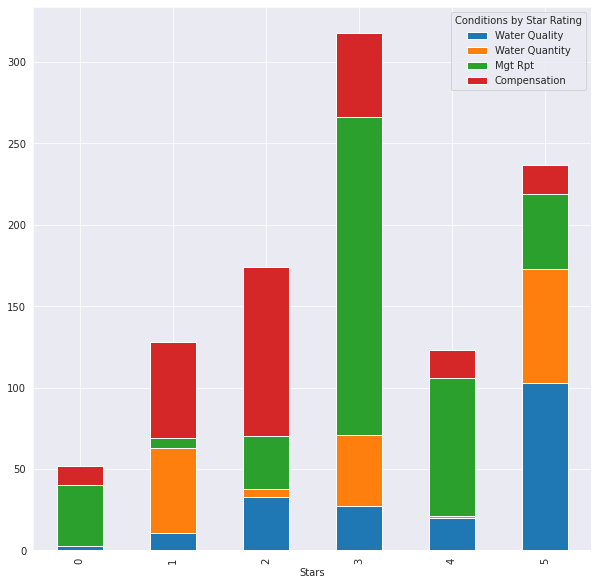

In [177]:
#df['Stars'].value_counts().plot.bar(rot=0,title='Condition Count Chart by Star Rating',xlabel='Stars',ylabel='No of Conditions',figsize=(10,10))
df.groupby(['Stars','Cond_Category']).size().unstack().plot(kind='bar',stacked=True,figsize=(10,10)).legend(["Water Quality","Water Quantity","Mgt Rpt","Compensation"],loc='upper right', title="Conditions by Star Rating")
sns.set_style("darkgrid")
plt.show()

In [178]:
df.describe()

,Determination_Year,Cond_Category,EScore,Stars
count,959.000000,1032.000000,1032.000000,1032.000000
mean,2016.163712,2.705426,0.496195,3.010659
std,2.575235,1.048045,0.299894,1.469008
min,2012.000000,1.000000,0.000000,0.000000
25%,2014.000000,2.000000,0.264937,2.000000
50%,2016.000000,3.000000,0.427500,3.000000
75%,2018.000000,4.000000,0.700000,4.000000
max,2021.000000,4.000000,1.000000,5.000000


In [136]:
df = df.drop(['Textfile','Sub_Header','Cond_Category','Determination_Year','EScore'],axis=1)

In [137]:
print(STOPWORDS)

{'into', 'off', 'myself', 'to', 'd', 'over', 'other', "wouldn't", 'didn', 'below', 'out', 'just', 'above', 'then', 'now', 'what', 'my', 'there', 'when', 'why', "wasn't", 'that', 'hers', 'all', 'ours', "mightn't", 'is', "weren't", "you'd", "that'll", 'these', 'on', 'm', 'nor', 'because', 'in', 'up', 'whom', 'of', 'haven', 'mustn', 'weren', 'have', 'your', 'their', 'through', 'will', 'who', 'don', 'had', 'before', 'own', 'those', "hadn't", 'yours', 'were', 'about', 'ourselves', 'i', 'ain', "aren't", 'did', 'after', 'same', 'being', 're', "she's", 'so', "it's", 'this', 'if', 'or', 'her', 'having', 'until', 'been', 'between', 'll', 'hadn', 'we', 'do', 'was', 'only', "you're", 'more', 'himself', 'than', 'aren', 'very', 's', 'be', 'here', 'doing', "isn't", "you'll", 've', 'too', "doesn't", 'theirs', 'are', 'by', 'should', "should've", 'any', "shouldn't", 'she', 'hasn', 'mightn', 'themselves', 'under', 'our', 'most', 'with', 'isn', 'and', "needn't", "haven't", 'yourself', 'such', 'some', 'aga

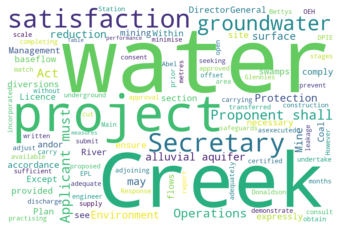

In [138]:
wordcloud = WordCloud(max_words=100, stopwords=STOPWORDS, background_color="white",width=1200,height=800).generate(str(df['Sub_Section']))
plt.imshow(wordcloud, interpolation='bilinear', )
plt.axis("off")
plt.show()
wordcloud.to_file("wordcloud1.png")

# Text Processing 

- Convert all text to lower case.
- Replace REPLACE_BY_SPACE_RE symbols by space in text.
- Remove symbols that are in BAD_SYMBOLS_RE from text.
- Remove stop words.
- Remove digits in text.
- Remove single letters


In [139]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
SINGLE_LETTERS_RE = re.compile('\s+[a-zA-Z]\s+')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove('should')
STOPWORDS.add('applicant')
STOPWORDS.add('proponent')
STOPWORDS.add('groundwater')
STOPWORDS.add('water')
STOPWORDS.add('environment')
STOPWORDS.add('act')
STOPWORDS.add('project')
STOPWORDS.add('creek')


def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = SINGLE_LETTERS_RE.sub('', text) # remove single letters
#    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

df['Sub_Section'] = df['Sub_Section'].apply(clean_text)
df['Sub_Section'] = df['Sub_Section'].str.replace('\d+', '')

In [140]:
print(df['Sub_Section'][600])

plan must consistent requirements managing urban stormwater soils construction manual landcom  latest version ii identify activities could cause soil erosion generate sediment iii describe measures minimise soil erosion potential transport sediment downstream waters iv describe location function capacity erosion sediment control structures v describe measures would implemented monitor maintain structures time


In [141]:
df['Sub_Section'].describe()

count                                                                                                 1032
unique                                                                                                 441
top       compensatory supply measures must provide alternative longterm supply equivalent loss attributed
freq                                                                                                    45
Name: Sub_Section, dtype: object

In [142]:

#count no of words in the sub_section string and in the total in the all the conditions
def word_count(text):

    return(len(text.strip().split(" ")))


tot_word = 0
word_no = []
for i in range(len(df)):
    
    word_no.append(word_count(str(df.iloc[i,0])))
    tot_word = tot_word + (word_count(str(df.iloc[i,0])))

df_word = pd.DataFrame(data=word_no,index=None)
                                     
print(f"Total words: {tot_word}")
df_word.describe()



Total words: 19458


,0
count,1032.000000
mean,18.854651
std,18.114149
min,1.000000
25%,9.000000
50%,13.000000
75%,20.000000
max,284.000000


<AxesSubplot:title={'center':'Condition Word Count Chart'}, xlabel='Word Count', ylabel='No of Conditions'>

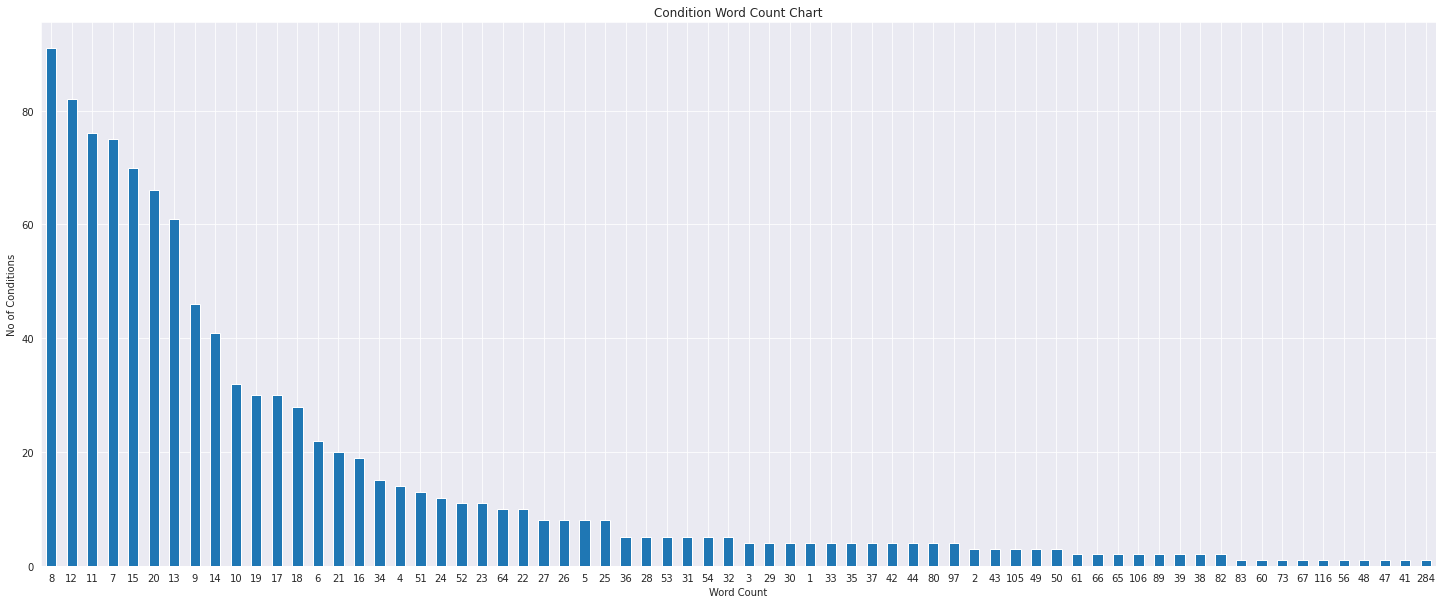

In [143]:
df_word[0].value_counts().plot.bar(rot=0,title='Condition Word Count Chart',xlabel='Word Count',ylabel='No of Conditions',figsize=(25,10))

In [144]:
#df['Stars'].groupby(df[].value_counts().plot.bar(rot=0,title='Condition Count Chart by Star Rating',xlabel='Stars',ylabel='No of Conditions',figsize=(10,10))
#df['Stars'].value_counts().plot.bar(rot=0,title='Condition Count Chart by Star Rating',xlabel='Stars',ylabel='No of Conditions',figsize=(10,10))

#df.Stars.value_counts().plot.hist(bins=5,title='Condition Star Count Chart',xlabel='Stars',ylabel='No of Conditions',figsize=(10,10))


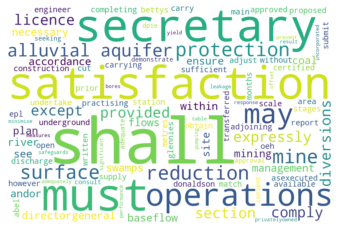

In [145]:
wordcloud = WordCloud(max_words=100, stopwords=STOPWORDS, background_color="white",width=1200,height=800).generate(str(df['Sub_Section']))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear', )
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("wordcloud2.png")

# Tokenising

- Vectorize text into either a sequence of integers or into a vector.
- Limit the data set to the top 125,0000 words.
- Set the max number of words for each sub_section at 500.
- Truncate and pad the subsections with zeros


In [146]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 3000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Sub_Section'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['Sub_Section'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Y = pd.get_dummies(df['Stars']).values
print('Shape of label tensor:', Y.shape)

Found 1019 unique tokens.
Shape of data tensor: (1032, 100)
Shape of label tensor: (1032, 6)


In [147]:
print((df['Stars']).values)

[5 3 4 ... 3 3 2]


In [181]:
df.median()

Determination_Year    2016.0000
Cond_Category            3.0000
EScore                   0.4275
Stars                    3.0000
dtype: float64

In [148]:
df['Stars'].describe()

count    1032.000000
mean        3.010659
std         1.469008
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Stars, dtype: float64

In [149]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(928, 100) (928, 6)
(104, 100) (104, 6)


In [150]:
#sns.lineplot(x=train.index, y="Stars", data=train);
#sns.lineplot(x=test.index, y="Stars", data=test);

In [151]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          300000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 381,006
Trainable params: 381,006
Non-trainable params: 0
_________________________________________________________________
None


In [152]:
epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
14/14 [==============================] - 4s 137ms/step - loss: 1.7459 - accuracy: 0.3268 - val_loss: 1.4648 - val_accuracy: 0.3656
Epoch 2/20
14/14 [==============================] - 2s 119ms/step - loss: 1.4905 - accuracy: 0.3478 - val_loss: 1.2248 - val_accuracy: 0.7312
Epoch 3/20
14/14 [==============================] - 2s 122ms/step - loss: 1.2493 - accuracy: 0.6509 - val_loss: 0.9980 - val_accuracy: 0.7419
Epoch 4/20
14/14 [==============================] - 2s 120ms/step - loss: 0.9833 - accuracy: 0.6788 - val_loss: 0.6895 - val_accuracy: 0.8280
Epoch 5/20
14/14 [==============================] - 2s 119ms/step - loss: 0.7039 - accuracy: 0.7501 - val_loss: 0.5888 - val_accuracy: 0.8280
Epoch 6/20
14/14 [==============================] - 2s 118ms/step - loss: 0.5158 - accuracy: 0.8286 - val_loss: 0.4936 - val_accuracy: 0.8710
Epoch 7/20
14/14 [==============================] - 2s 120ms/step - loss: 0.3938 - accuracy: 0.8585 - val_loss: 0.4564 - val_accuracy: 0.8387
Epoch 

In [153]:
# save the model to disk
model.save('jup_enforceability_model.h5')
joblib.dump(tokenizer, "jup_data_tokenizer.joblib")

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4/4 [==============================] - 0s 15ms/step - loss: 0.3999 - accuracy: 0.9038
Test set
  Loss: 0.400
  Accuracy: 0.904


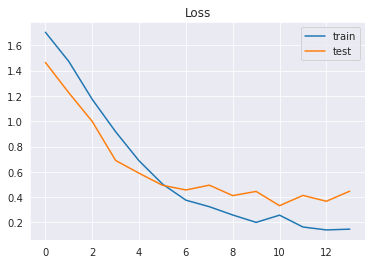

In [154]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [155]:
print(history.history)

{'loss': [1.7035062313079834, 1.4722771644592285, 1.1727749109268188, 0.9163722395896912, 0.6869812607765198, 0.5034240484237671, 0.37573128938674927, 0.32415154576301575, 0.258591890335083, 0.20018653571605682, 0.25717613101005554, 0.16343970596790314, 0.14052698016166687, 0.14645634591579437], 'accuracy': [0.3640718460083008, 0.39880239963531494, 0.6658682823181152, 0.7173652648925781, 0.7676646709442139, 0.8347305655479431, 0.8754491209983826, 0.9149700403213501, 0.940119743347168, 0.9520958065986633, 0.9341317415237427, 0.9556885957717896, 0.9676646590232849, 0.9676646590232849], 'val_loss': [1.4647599458694458, 1.2247812747955322, 0.9980143904685974, 0.6895372867584229, 0.5888389945030212, 0.4936414361000061, 0.4564129710197449, 0.4944063425064087, 0.4118816554546356, 0.4450376629829407, 0.3321857750415802, 0.41312363743782043, 0.36724796891212463, 0.44700467586517334], 'val_accuracy': [0.3655914068222046, 0.7311828136444092, 0.7419354915618896, 0.8279569745063782, 0.8279569745063

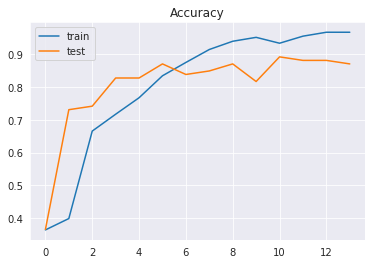

In [156]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [183]:
tokenizer = joblib.load("jup_data_tokenizer.joblib")

new_sub_header = ['Unless an EPL authorises otherwise, the Applicant must comply with Section 120 of the POEO Act.']

df_new = pd.DataFrame(new_sub_header)
df_new[0] = df_new[0].apply(clean_text)
df_new[0] = df_new[0].str.replace('\d+', '')

pd.set_option('display.max_colwidth', None)
print(str(df_new[0]))


seq = tokenizer.texts_to_sequences(df_new[0].values)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', padded.shape)
print(padded)

pred = model.predict(padded)
labels = ['0','1', '2', '3', '4', '5']
print(pred, labels[np.argmax(pred)])
#print(pred,[np.argmax(pred)])                 

0    unless epl authorises otherwise applicant must comply section  poeo act
Name: 0, dtype: object
Shape of data tensor: (1, 100)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  71  37 114  76   1  19  87  92]]
[[3.9848015e-03 2.4241825e-04 3.1813520e-03 4.0561910e-04 2.5947047e-03
  9.8959106e-01]] 5


In [114]:
Y_test.reshape(-1,1)
#pred.reshape(-1,1)
confusion_matrix(Y_test.argmax(axis=1), pred.argmax(axis=1))


ValueError: Found input variables with inconsistent numbers of samples: [104, 1]